## Import our libraries

In [1]:
%matplotlib inline
import numpy as np
#for the sigmoid function we need expit() from scipy
import scipy.special
#library for plotting arrays
import matplotlib.pyplot as plt
# A particularly interesting backend, provided by IPython, is the inline backend. 
# This is available only for the Jupyter Notebook and the Jupyter QtConsole. 
# It can be invoked as follows: %matplotlib inline
# With this backend, the output of plotting commands is displayed inline 
# within frontends like the Jupyter notebook, directly below the code cell that produced it. 
# The resulting plots are inside this notebook, not an external window.

import pandas as pd # to manage data frames and reading csv files

## Set our Global Variables
later you will need to modify these to present your solution to the Exercise

In [2]:
#number of input, hidden and output nodes
input_nodes = 784 #we have 28 * 28 matrix to describe each digit
hidden_nodes = 200
output_nodes = 10

learning_rate = 0.3
batch_size = 10

# epochs is the number of training iterations 
epochs = 30

# datasets to read
# you can change these when trying out other datasets
train_file = "data/mnist_train.csv"
test_file = "data/mnist_test.csv"

In [3]:
#load the mnist training data CSV file into a list
train_data_file = open(train_file, 'r')
train_data_list = train_data_file.readlines() # read all lines into memory 
train_data_file.close() 
print("train set size: ", len(train_data_list))

#testing the network
#load the mnist test data CSV file into a list
#test_data_file = open("mnist/mnist_test_10.csv", 'r') # read the file with 10 instances first
test_data_file = open(test_file, 'r') # read the file with 10 instances first
test_data_list = test_data_file.readlines()
test_data_file.close()
print("test set size: ", len(test_data_list))

train set size:  60000
test set size:  10000


In [4]:
class neuralNetwork:
    """Artificial Neural Network classifier.

    Parameters
    ------------
    lr : float
      Learning rate (between 0.0 and 1.0)
    ep : int
      Number of epochs for training the network towards achieving convergence
    batch_size : int
      Size of the training batch to be used when calculating the gradient descent. 
      batch_size = 0 standard gradient descent
      batch_size > 0 stochastic gradient descent 

    inodes : int
      Number of input nodes which is normally the number of features in an instance.
    hnodes : int
      Number of hidden nodes in the net.
    onodes : int
      Number of output nodes in the net.


    Attributes
    -----------
    wih : 2d-array
      Input2Hidden node weights after fitting 
    who : 2d-array
      Hidden2Output node weights after fitting 
    E : list
      Sum-of-squares error value in each epoch.
      
    Results : list
      Target and predicted class labels for the test data.
      
    Functions
    ---------
    activation_function : float (between 1 and -1)
        implments the sigmoid function which squashes the node input

    """

    def __init__(self, inputnodes=784, hiddennodes=200, outputnodes=10, learningrate=0.3, batch_size=10, epochs=30):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        #link weight matrices, wih (input to hidden) and who (hidden to output)
        #a weight on link from node i to node j is w_ij
        
        
        #Draw random samples from a normal (Gaussian) distribution centered around 0.
        #numpy.random.normal(loc to centre gaussian=0.0, scale=1, size=dimensions of the array we want) 
        #scale is usually set to the standard deviation which is related to the number of incoming links i.e. 
        #1/sqrt(num of incoming inputs). we use pow to raise it to the power of -0.5.
        #We have set 0 as the centre of the guassian dist.
        # size is set to the dimensions of the number of hnodes, inodes and onodes
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        #set the learning rate
        self.lr = learningrate
        
        #set the batch size
        self.bs = batch_size
        
        #set the number of epochs
        self.ep = epochs
        
        #store errors at each epoch
        self.E= []
        
        #store results from testing the model
        #keep track of the network performance on each test instance
        self.results= []
        
        #define the activation function here
        #specify the sigmoid squashing function. Here expit() provides the sigmoid function.
        #lambda is a short cut function which is executed there and then with no def (i.e. like an anonymous function)
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass
    
   
    def batch_input(self, input_list):
        """Yield consecutive batches of the specified size from the input list."""
        for i in range(0, len(input_list), self.bs):
            yield input_list[i:i + self.bs]
    
    #train the neural net
    #note the first part is very similar to the query function because they both require the forward pass
    def train(self, train_inputs):
        """Training the neural net. 
           This includes the forward pass ; error computation; 
           backprop of the error ; calculation of gradients and updating the weights.

            Parameters
            ----------
            train_inputs : {array-like}, shape = [n_instances, n_features]
            Training vectors, where n_instances is the number of training instances and
            n_features is the number of features.
            Note this contains all features including the class feature which is in first position
        
            Returns
            -------
            self : object
        """
        self.hybrid_values = []
        self.hybrid_class = []
        for e in range(self.ep):
            print("Training epoch#: ", e)
            sum_error = 0.0   
            for batch in self.batch_input(train_inputs):
                #creating variables to store the gradients   
                delta_who = 0
                delta_wih = 0
                
                # iterate through the inputs sent in
                for instance in batch:
                    # split it by the commas
                    all_values = instance.split(',')
                    self.hybrid_class.append(all_values[0])
                    # scale and shift the inputs to address the problem of diminishing weights due to multiplying by zero
                    # divide the raw inputs which are in the range 0-255 by 255 will bring them into the range 0-1
                    # multiply by 0.99 to bring them into the range 0.0 - 0.99.
                    # add 0.01 to shift them up to the desired range 0.01 - 1. 
                    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
                    #create the target output values for each instance so that we can use it with the neural net
                    #note we need 10 nodes where each represents one of the digits
                    targets = np.zeros(output_nodes) + 0.01 #all initialised to 0.01
                    #all_value[0] has the target class label for this instance
                    targets[int(all_values[0])] = 0.99
        
                    #convert  inputs list to 2d array
                    inputs = np.array(inputs,  ndmin=2).T
                    targets = np.array(targets, ndmin=2).T

                    #calculate signals into hidden layer
                    hidden_inputs = np.dot(self.wih, inputs)
                    #calculate the signals emerging from the hidden layer
                    hidden_outputs = self.activation_function(hidden_inputs)

                    #calculate signals into final output layer
                    final_inputs=np.dot(self.who, hidden_outputs)
                    
                    self.hybrid_values.append(hidden_outputs)
                    #calculate the signals emerging from final output layer
                    final_outputs = self.activation_function(final_inputs)
        
                    #to calculate the error we need to compute the element wise diff between target and actual
                    output_errors = targets - final_outputs
                    #Next distribute the error to the hidden layer such that hidden layer error
                    #is the output_errors, split by weights, recombined at hidden nodes
                    hidden_errors = np.dot(self.who.T, output_errors)
            
                       
                    ## for each instance accumilate the gradients from each instance
                    ## delta_who are the gradients between hidden and output weights
                    ## delta_wih are the gradients between input and hidden weights
                    delta_who += np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
                    delta_wih += np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
                    
                    sum_error += np.dot(output_errors.T, output_errors)#this is the sum of squared error accumilated over each batced instance
                   
                pass #instance
            
                # update the weights by multiplying the gradient with the learning rate
                # note that the deltas are divided by batch size to obtain the average gradient according to the given batch
                # obviously if batch size = 1 then we dont need to bother with an average
                self.who += self.lr * (delta_who / self.bs)
                self.wih += self.lr * (delta_wih / self.bs)
            pass # batch
            self.E.append(np.asfarray(sum_error).flatten())
            print("errors (SSE): ", self.E[-1])
        pass # epoch
    
    #query the neural net
    def query(self, inputs_list):
        #convert inputs_list to a 2d array
        #print(numpy.matrix(inputs_list))
        #inputs_list [[ 1.   0.5 -1.5]]
        inputs = np.array(inputs_list, ndmin=2).T 
        #once converted it appears as follows
        #[[ 1. ]
        # [ 0.5]
        # [-1.5]]
        #print(numpy.matrix(inputs))
        
        #propogate input into hidden layer. This is the start of the forward pass
        hidden_inputs = np.dot(self.wih, inputs)
        
        
        #squash the content in the hidden node using the sigmoid function (value between 1, -1)
        hidden_outputs = self.activation_function(hidden_inputs)
                
        #propagate into output layer and the apply the squashing sigmoid function
        final_inputs = np.dot(self.who, hidden_outputs)
        
        final_outputs = self.activation_function(final_inputs)
        return final_outputs
    
     
    #iterate through all the test data to calculate model accuracy
    def test(self, test_inputs):
        self.results = []
        
        #go through each test instances
        for instance in test_inputs:
            all_values = instance.split(',') # extract the input feature values for the instance
    
            target_label = int(all_values[0]) # get the target class for the instance
    
            #scale and shift the inputs this is to make sure values dont lead to zero when multiplied with weights
            inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    
            #query the network with test inputs
            #note this returns 10 output values ; of which the index of the highest value
            # is the networks predicted class label
            outputs = self.query(inputs)
    
            #get the index of the highest output node as this corresponds to the predicted class
            predict_label = np.argmax(outputs) #this is the class predicted by the ANN
    
            self.results.append([predict_label, target_label])
            #compute network error
            #if (predict_label == target_label):
            #    self.results.append(1)
            #else: 
            #    self.results.append(0)
            pass
        pass
        self.results = np.asfarray(self.results) # flatten results to avoid nested arrays
    
        
    

In [5]:
# train_data_list

## Train the Artificial Neural Net

In [6]:
#create instance of neuralnet
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size, epochs)

# numpy.random.choice generates a random sample from a given 1-D array
# we can use this to select a sample from our training data in case we want to work with a small sample
# for instance we use a small sample here such as 1500
# mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
mini_training_data = train_data_list[:1500]
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)
n.train(mini_training_data)

# n.train(train_data_list)

Percentage of training data used: 2.5
Training epoch#:  0
errors (SSE):  [601.59229778]
Training epoch#:  1
errors (SSE):  [322.50894568]
Training epoch#:  2
errors (SSE):  [266.29124565]
Training epoch#:  3
errors (SSE):  [230.16940996]
Training epoch#:  4
errors (SSE):  [202.85824199]
Training epoch#:  5
errors (SSE):  [181.03821225]
Training epoch#:  6
errors (SSE):  [163.0610146]
Training epoch#:  7
errors (SSE):  [147.93148176]
Training epoch#:  8
errors (SSE):  [135.09980422]
Training epoch#:  9
errors (SSE):  [124.12942223]
Training epoch#:  10
errors (SSE):  [114.56135179]
Training epoch#:  11
errors (SSE):  [106.0691998]
Training epoch#:  12
errors (SSE):  [98.43124873]
Training epoch#:  13
errors (SSE):  [91.46580164]
Training epoch#:  14
errors (SSE):  [85.06148525]
Training epoch#:  15
errors (SSE):  [79.15790905]
Training epoch#:  16
errors (SSE):  [73.72932086]
Training epoch#:  17
errors (SSE):  [68.77283096]
Training epoch#:  18
errors (SSE):  [64.24479121]
Training epo

## Plot the model error with increasing epochs

Error at the end of each epoch has been stored in self.E
We can now use mathplotlib to plot the error at the end of each epoch. 
Our expectation is that as we continue to descend (hill-walking) we should move closer to the minima
as such error should decrease. 

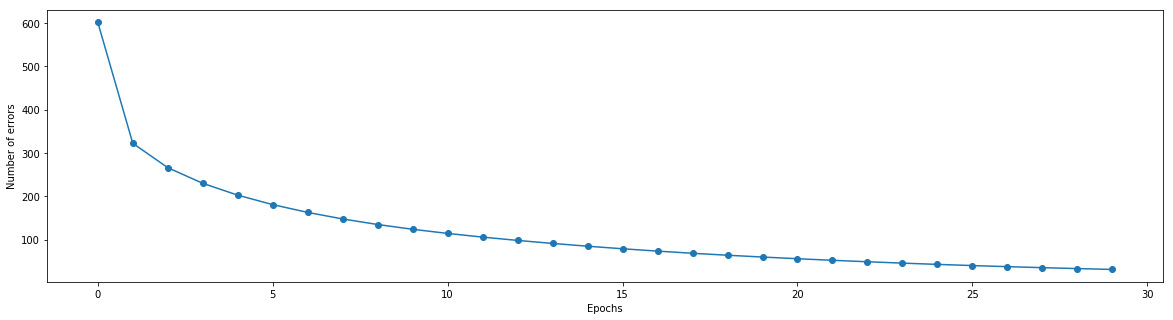

In [7]:
#print the error over epochs

plt.figure(figsize=(20,5)) #width, height settings for figures
plt.plot(range(0, n.ep), np.asfarray(n.E), marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of errors')



# plt.savefig('images/02_07.png', dpi=300)
plt.show()

## Test the ANN and compute the Accuracy
We will keep track of the predicted and actual outputs in order to 
calculate the accuracy of the model on the unseen test data. 


In [8]:
n.test(test_data_list)
#print network performance as an accuracy metric
correct = 0 # number of predictions that were correct

#iteratre through each tested instance and accumilate number of correct predictions
for result in n.results:
    if (result[0] == result[1]):
            correct += 1
    pass
pass

# print the accuracy on test set
print ("Test set accuracy% = ", (100 * correct / len(n.results)))

Test set accuracy% =  90.21


In [9]:
new_dataset = []

for row in range(0, len(n.hybrid_values)):
    my_row = []
    my_row.append(n.hybrid_class[row])
    for col in range(0, len(n.hybrid_values[row])):
        my_row.append(n.hybrid_values[row][col][0])
    new_dataset.append(my_row)
                   
   
        

In [10]:
hybrid_data = pd.DataFrame(new_dataset)

In [11]:
hybrid_data

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,5,0.494230,0.467823,0.595076,0.388914,0.467764,0.517085,0.533080,0.564102,0.429205,...,0.456384,0.617726,0.401893,0.437372,0.510095,0.512113,0.501598,0.475575,0.445245,0.380133
1,0,0.624591,0.424304,0.650029,0.391525,0.421695,0.421476,0.312537,0.534023,0.486113,...,0.439536,0.652906,0.423631,0.478065,0.608949,0.648437,0.423185,0.504391,0.322251,0.527458
2,4,0.617798,0.534772,0.571680,0.465620,0.483293,0.453296,0.568256,0.489467,0.533587,...,0.490198,0.593565,0.375059,0.573670,0.497906,0.473200,0.483968,0.440581,0.465039,0.483879
3,1,0.423545,0.390823,0.529562,0.364918,0.543253,0.414250,0.444813,0.500588,0.424529,...,0.447035,0.466065,0.400395,0.578492,0.528461,0.351093,0.502654,0.497462,0.509921,0.440470
4,9,0.434693,0.400409,0.684090,0.443029,0.540683,0.388294,0.455705,0.571975,0.489039,...,0.443192,0.491207,0.287157,0.473730,0.447597,0.422574,0.480675,0.392080,0.567889,0.363806
5,2,0.658381,0.430957,0.573086,0.499354,0.555867,0.326530,0.501080,0.600948,0.427330,...,0.443569,0.611450,0.280616,0.537071,0.458861,0.391992,0.474362,0.437483,0.489106,0.412709
6,1,0.513190,0.363113,0.622211,0.478259,0.515056,0.447807,0.418159,0.544871,0.543357,...,0.419029,0.513147,0.550448,0.519971,0.434781,0.330372,0.565793,0.518561,0.402986,0.399268
7,3,0.660594,0.491482,0.610683,0.373437,0.583428,0.517546,0.478933,0.611986,0.499411,...,0.405028,0.577689,0.361144,0.554764,0.457009,0.529344,0.358498,0.503486,0.456975,0.319535
8,1,0.543546,0.389894,0.537208,0.511608,0.501795,0.424094,0.501251,0.471739,0.548973,...,0.423703,0.448869,0.498349,0.504824,0.426270,0.399242,0.509458,0.468201,0.491694,0.425091
9,4,0.674716,0.399831,0.569309,0.497585,0.489677,0.417305,0.558413,0.667773,0.458999,...,0.453993,0.631944,0.398568,0.525464,0.347463,0.552696,0.460307,0.558235,0.560515,0.306293


In [12]:
def load_dataset(dataframe, split=0.8, fraction = 1.0):
    
    dataframe = dataframe.sample(frac=fraction, replace=True)
    
    
    #Rearange to make first column the last
    
#     print("Before")
#     print(dataframe.head())
    
    cols = dataframe.columns.tolist()
    cols = cols[-(len(cols)-1):] + cols[:-(len(cols)-1)]
    
    dataframe = dataframe[cols]
    
    
    print(len(dataframe.columns.tolist()))
    
#     print("After")
#     print(dataframe.head())
    
    
    
    #Overide to Class_index to always be the Last Column
    class_idx = len(dataframe.columns)-1
    
    
    #dataframe = dataframe.sample(len(dataframe))
    instances = dataframe.values


    print ("Class Index: "+str(class_idx))
    # dpockemivide data into label and feature sets.
    X = instances[:,0:class_idx] # you may need to change these depending on which dataset you are use
    Y = instances[:,class_idx] 
    
#     print("X",X,":","Y",Y)
    
   
    X_train = [] # features for the train set
    Y_train = [] # class labels for the train set
    X_test = [] # features for the test set
    Y_test = [] # class labels for the test set
    
    # the zip iterator is a neat construct in Python
    # it lets you iterate over 2 arrays / lists structures 
    # importantly it iterates upto the length of the smallest structure of the two 
    # in our case X and Y will be of same length
    for  x, y in zip(X, Y): 
        if random.random() < split: # Return the next random floating point number in the range [0.0, 1.0) and compare
            X_train.append(x)
            Y_train.append(y)
        else:
            X_test.append(x)
            Y_test.append(y)       
    print("train set size: ", len(X_train))       
    print("test set size: ", len(X_test))
    
    return X_train, Y_train, X_test, Y_test

In [13]:
#Within our class we now need code for each of the components of k-NN.
#First, lets create a method that will measure the distance between two vectors.
def euclidean(instance1, instance2):
        '''
        Calculates euclidean distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):            
            distance += pow((val1 - val2), 2)
        
        distance = pow(distance, 1/2)
             
              
        return 1 / (1+ distance)
    

def manhattan(instance1, instance2):
        '''
        Calculates manhattan distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):
            distance += abs(val1 - val2)      
              
        return 1 / (1+ distance)
    
def dot_product(instance1, instance2):
        '''
        Calculates dot product between two instances 
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        return np.dot(instance1, instance2)

In [14]:
#Finally, we can test to see how many of the test instances we got correct
def accuracy(results):
    correct = 0
    for predict, target in results:

        if predict == target:
            correct += 1
    return (correct/float(len(results))) * 100.0

In [15]:
class kNN:
    """
    Parameters
    X_train, Y_train : list
    these consists of the training set feature values and associated class labels
    k : int
    specify the number of neighbours
    sim : literal
    specify the name of the similarity metric (e.g. manhattan, eucliedean)
    weighted : Boolean
    specify the voting strategy as weighted or not weighted by similarity values
  
    Attributes
    -----------  
    Results : list
      Target and predicted class labels for the test data.    
    """


    def __init__(self, X_train, Y_train, k=3, sim=euclidean, weighted=False):
        self.X_train = X_train
        self.Y_train = Y_train
        
        if k <= len(self.X_train):
            self.k = k # set the k value for neighbourhood size
        else:
            self.k = len(self.X_train) # to ensure the get_neighbours dont crash
    
        self.similarity = sim # specify a sim metric that has been pre-defined e.g. manhattan or euclidean
        
        self.weighted = weighted # boolean to choose between weighted / unweighted majority voting
        
        #store results from testing 
        self.results= []
        
    #With k-NN, we are interested in finding the k number of points with the greatest similarity 
    # to the the query or test instance.
    def get_neighbours(self, test_instance):
        '''
        Locate most similar neighbours 
        X_train will be a containing features (Float) values (i.e. your training data)
        Y_train will be the corresponding class labels for each instance in X_train
        test_instance will be a List of Float values (i.e. a query instance)
        '''
        similarities = [] # collection to store the similarities to be computed

        for train_instance, y in zip(self.X_train, self.Y_train): #for each member of the training set
            sim = self.similarity(test_instance, train_instance) #calculate the similarity to the test instance
            
            similarities.append((y, sim)) #add the actual label of the example and the computed similarity to a collection 
        #print(distances)
        similarities.sort(key = operator.itemgetter(1), reverse = True) #sort the collection by decreasing similarity
        neighbours = [] # holds the k most similar neighbours
        for x in range(self.k): #extract the k top indices of the collection for return
            neighbours.append(similarities[x])

        return neighbours

    # given the neighbours make a prediction
    # the boolean parameter when set to False will use unweighted majority voting; otherwise weighted majority voting
    # weighting can be helpful to break any ties in voting
    def predict(self, neighbours):
        '''
        Summarise a prediction based upon weighted neighbours calculation
        '''
        class_votes = {}
        for x in range(len(neighbours)):
            response = neighbours[x][0]
            if response in class_votes:
                class_votes[response] += (1-self.weighted) + (self.weighted * neighbours[x][1]) #if not weighted simply add 1
                #class_votes[response] += [1, neighbours[x][1]][weighted == True] 
              
            else:
                class_votes[response] = (1-self.weighted) + (self.weighted * neighbours[x][1])
                #class_votes[response] = [1, neighbours[x][1]][weighted == True] 
                
        #print(class_votes)
        sorted_votes = sorted(class_votes, key = lambda k: (class_votes[k], k), reverse = True)
        #print(sorted_votes)
        return sorted_votes[0]
    
    #iterate through all the test data to calculate accuracy
    def test(self, X_test, Y_test):
        self.results = [] # store the predictions returned by kNN

        for test_instance, target_label in zip(X_test, Y_test):
            neighbours = self.get_neighbours(test_instance)
#             print(neighbours)
            predict_label = self.predict(neighbours)
            self.results.append([predict_label, target_label])
            #print('> predicted = ', result,', actual = ', test_label)
    

In [16]:
#Load the dataset and maintain the features (X) and class labels (Y) separately  
# make sure you understand what the 4 and 0.8 default values are in the call
# you may have to modify these depending on the dataset you work with.
import random
import math
import operator
X_train, Y_train, X_test, Y_test = load_dataset(hybrid_data, split=0.8, fraction=0.015)

201
Class Index: 200
train set size:  534
test set size:  141


In [17]:
knn = kNN(X_train, Y_train, k=int(math.sqrt(len(Y_test))), weighted=True)
knn.test(X_test, Y_test) # now get the predictions on the test set

print("kNN Accuracy on test set is: ", accuracy(knn.results))

kNN Accuracy on test set is:  84.39716312056737
